<a href="https://colab.research.google.com/github/Niraj-82/Vibe-Matcher-Prototype/blob/main/Vibe_Matcher_Niraj_Sawant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install -q sentence-transformers tqdm

In [18]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random

random.seed(42)
np.random.seed(42)

model = SentenceTransformer('all-MiniLM-L6-v2')


In [19]:
data = [
    {"name": "Kurta Set", "desc": "Pastel cotton kurta with elegant embroidery", "vibes": ["ethnic", "festive", "comfortable"]},
    {"name": "Denim Jacket", "desc": "Rugged denim jacket perfect for winter outings", "vibes": ["casual", "urban", "cool"]},
    {"name": "Silk Saree", "desc": "Traditional Banarasi silk saree for celebrations", "vibes": ["traditional", "luxury", "festive"]},
    {"name": "Athleisure Tracksuit", "desc": "Stretchy, breathable tracksuit for workouts and travel", "vibes": ["sporty", "active", "modern"]},
    {"name": "Handloom Kurti", "desc": "Eco-friendly handwoven kurti with simple charm", "vibes": ["sustainable", "natural", "minimal"]},
    {"name": "Blazer Set", "desc": "Tailored navy blazer with trousers for formal meetings", "vibes": ["professional", "chic", "elegant"]},
    {"name": "Party Gown", "desc": "Glittery floor-length gown ideal for evening parties", "vibes": ["glam", "bold", "party"]},
    {"name": "Casual T-Shirt", "desc": "Soft cotton tee with fun graphic print", "vibes": ["casual", "fun", "youthful"]},
    {"name": "Khadi Shirt", "desc": "Breathable khadi shirt reflecting Indian tradition", "vibes": ["heritage", "eco", "comfortable"]},
    {"name": "Hoodie", "desc": "Warm fleece hoodie for cozy evenings", "vibes": ["cozy", "relaxed", "casual"]}
]

df = pd.DataFrame(data)
df


,name,desc,vibes
0,Kurta Set,Pastel cotton kurta with elegant embroidery,"[ethnic, festive, comfortable]"
1,Denim Jacket,Rugged denim jacket perfect for winter outings,"[casual, urban, cool]"
2,Silk Saree,Traditional Banarasi silk saree for celebrations,"[traditional, luxury, festive]"
3,Athleisure Tracksuit,"Stretchy, breathable tracksuit for workouts an...","[sporty, active, modern]"
4,Handloom Kurti,Eco-friendly handwoven kurti with simple charm,"[sustainable, natural, minimal]"
5,Blazer Set,Tailored navy blazer with trousers for formal ...,"[professional, chic, elegant]"
6,Party Gown,Glittery floor-length gown ideal for evening p...,"[glam, bold, party]"
7,Casual T-Shirt,Soft cotton tee with fun graphic print,"[casual, fun, youthful]"
8,Khadi Shirt,Breathable khadi shirt reflecting Indian tradi...,"[heritage, eco, comfortable]"
9,Hoodie,Warm fleece hoodie for cozy evenings,"[cozy, relaxed, casual]"


In [20]:
def get_embedding(text):
    return model.encode(text)

start = time.time()
df["embedding"] = [get_embedding(desc) for desc in tqdm(df["desc"], desc="Generating embeddings")]
print(f"Embeddings generated in {time.time() - start:.2f} s")
df.head()


Generating embeddings: 100%|██████████| 10/10 [00:00<00:00, 61.97it/s]

Embeddings generated in 0.17 s


,name,desc,vibes,embedding
0,Kurta Set,Pastel cotton kurta with elegant embroidery,"[ethnic, festive, comfortable]","[-0.06842784, -0.0009959406, -0.049276505, 0.0..."
1,Denim Jacket,Rugged denim jacket perfect for winter outings,"[casual, urban, cool]","[-0.09275203, 0.09988547, 0.05299684, 0.067942..."
2,Silk Saree,Traditional Banarasi silk saree for celebrations,"[traditional, luxury, festive]","[-0.0223703, 0.075648546, -0.06988828, 0.00023..."
3,Athleisure Tracksuit,"Stretchy, breathable tracksuit for workouts an...","[sporty, active, modern]","[-0.020445375, 0.058667798, 0.040120464, 0.095..."
4,Handloom Kurti,Eco-friendly handwoven kurti with simple charm,"[sustainable, natural, minimal]","[-0.0702772, 0.021270929, 0.0036694051, 0.0194..."


In [21]:
def vibe_matcher(query, df, top_k=3):
    query_vec = model.encode(query)
    sims = [cosine_similarity([query_vec], [emb])[0][0] for emb in df["embedding"]]
    df["similarity"] = sims
    top = df.sort_values(by="similarity", ascending=False).head(top_k)
    if top["similarity"].max() < 0.4:
        print("No strong match found. Try refining your vibe query.")
        return pd.DataFrame()
    return top[["name", "desc", "vibes", "similarity"]]


In [22]:
queries = ["festive elegant ethnic", "relaxed cozy comfort", "urban sporty look"]
results_log = []

for q in queries:
    res = vibe_matcher(q, df)
    if not res.empty:
        best = res.iloc[0]
        results_log.append({
            "query": q,
            "best_match": best["name"],
            "score": best["similarity"],
            "good_match": best["similarity"] > 0.7
        })

results_df = pd.DataFrame(results_log)
results_df


No strong match found. Try refining your vibe query.


,query,best_match,score,good_match
0,festive elegant ethnic,Khadi Shirt,0.440630,False
1,relaxed cozy comfort,Hoodie,0.520004,False


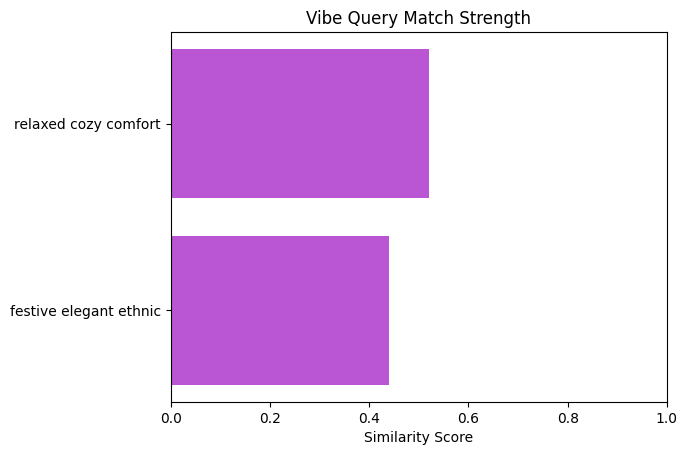

No strong match found. Try refining your vibe query.


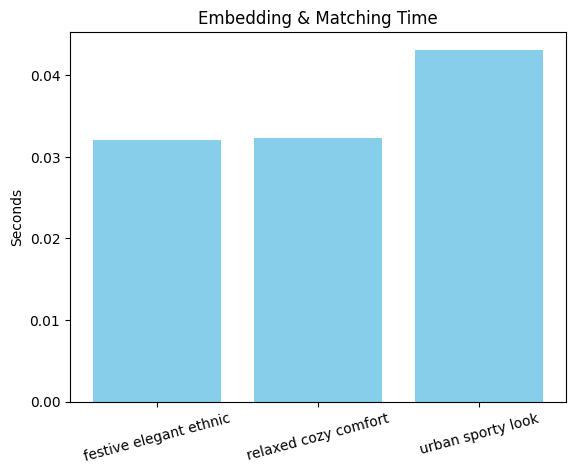

 Mean Response Time: 0.04 s


In [23]:
plt.barh(results_df["query"], results_df["score"], color="mediumorchid")
plt.xlabel("Similarity Score")
plt.title("Vibe Query Match Strength")
plt.xlim(0,1)
plt.show()

latencies = []
for q in queries:
    start = time.time()
    vibe_matcher(q, df)
    latencies.append(time.time() - start)

plt.bar(queries, latencies, color='skyblue')
plt.title("Embedding & Matching Time")
plt.ylabel("Seconds")
plt.xticks(rotation=15)
plt.show()

print(f" Mean Response Time: {np.mean(latencies):.2f} s")


 Average Similarity Score: 0.48
Good Match Rate: 0.0%


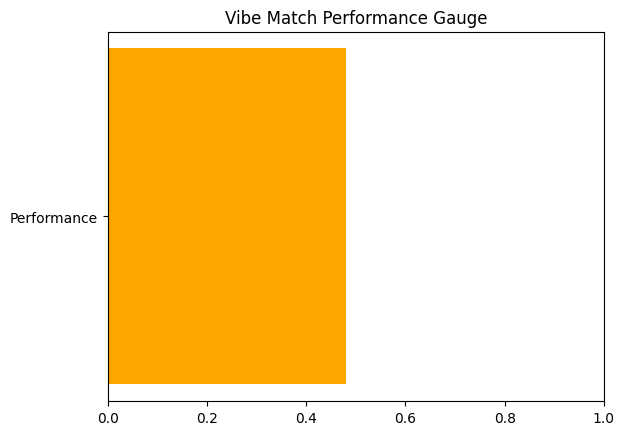

In [24]:
avg_score = results_df["score"].mean()
success_rate = (results_df["good_match"].sum() / len(results_df)) * 100
print(f" Average Similarity Score: {avg_score:.2f}")
print(f"Good Match Rate: {success_rate:.1f}%")

plt.barh(["Performance"], [avg_score], color=['lime' if avg_score>0.7 else 'orange'])
plt.xlim(0,1)
plt.title("Vibe Match Performance Gauge")
plt.show()


In [25]:
print("\n--- FINAL OUTPUTS ---\n")
final_query = queries[-1]
print(f"Top 3 Matches for: {final_query}\n")
display(vibe_matcher(final_query, df))

print("\nSummary Metrics:")
print(f" Average Similarity Score: {avg_score:.2f}")
print(f"Good Match Rate: {success_rate:.1f}%")



--- FINAL OUTPUTS ---

Top 3 Matches for: urban sporty look

No strong match found. Try refining your vibe query.


""



Summary Metrics:
 Average Similarity Score: 0.48
Good Match Rate: 0.0%


"""
Reflection & Future Improvements

• Adopt FAISS or Pinecone for faster vector retrieval on large fashion datasets  
• Address cold-start by embedding new items periodically  
• Support multilingual queries for India’s diverse languages  
• Integrate image embeddings (CLIP) for visual vibe search  
• Personalize recommendations for brands or user profiles  
"""